In [1]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from triplet_utils import *
from utils import *
from torch.utils.data import random_split
from triplet_utils import train_and_evaluate_triplet

# 2. Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 3. Create the dataset and dataloader
folder_path = '../../data/BiteCount/salient_poses/'   # Adjust this path
dataset = TripletDataset(folder_path, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

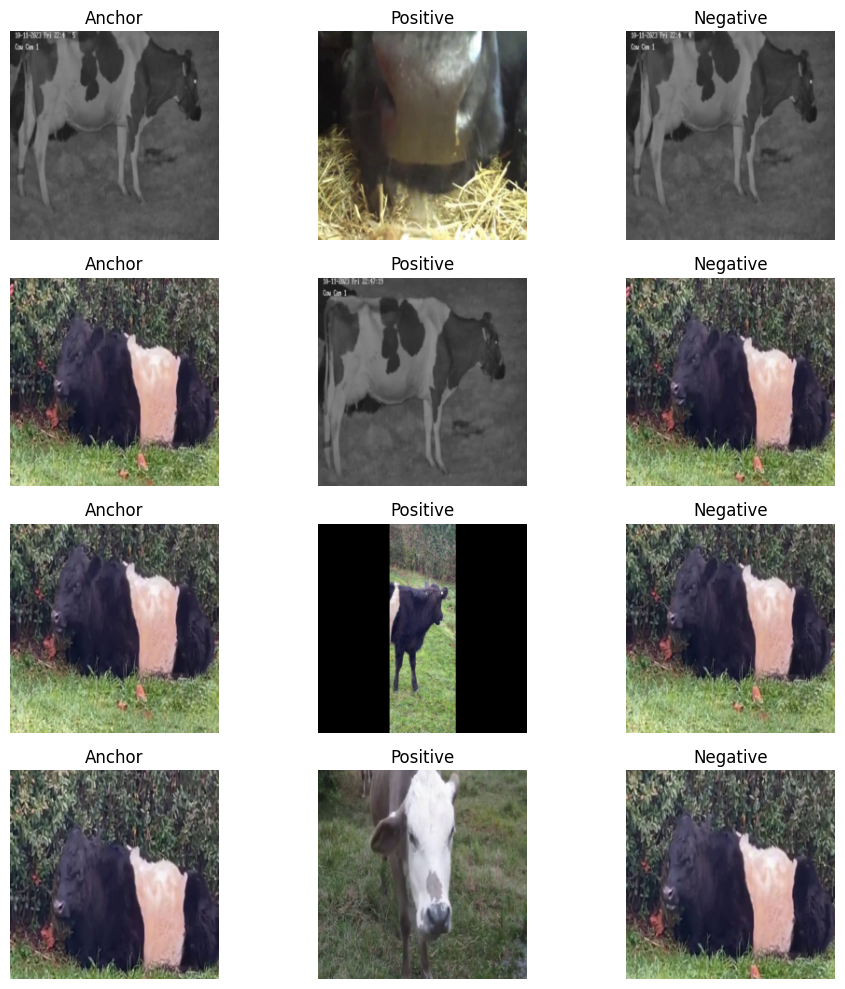

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show a batch of triplets
def show_triplet_images(dataloader, num_triplets=4):
    # Get a batch of data
    anchor_batch, positive_batch, negative_batch, _ = next(iter(dataloader))
    
    # Set up matplotlib subplots
    fig, axes = plt.subplots(num_triplets, 3, figsize=(10, 10))

    # Convert tensors to numpy arrays for visualization
    def convert_tensor_to_img(tensor):
        # Convert to numpy, [C, H, W] -> [H, W, C]
        image = tensor.numpy().transpose((1, 2, 0))  # Permute to [H, W, C]
        image = np.clip(image, 0, 1)  # Clip any out-of-bound values (if necessary)
        return image
    
    # Show num_triplets triplet images (anchor, positive, negative)
    for i in range(num_triplets):
        # No need to permute in the caller; it is done inside convert_tensor_to_img
        anchor_img = convert_tensor_to_img(anchor_batch[i])
        positive_img = convert_tensor_to_img(positive_batch[i])
        negative_img = convert_tensor_to_img(negative_batch[i])

        # Display anchor, positive, negative in a row
        axes[i, 0].imshow(anchor_img)
        axes[i, 0].set_title('Anchor')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(positive_img)
        axes[i, 1].set_title('Positive')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(negative_img)
        axes[i, 2].set_title('Negative')
        axes[i, 2].axis('off')

    # Adjust spacing between plots
    plt.tight_layout()
    plt.show()

# Example usage
show_triplet_images(dataloader, num_triplets=4)


In [3]:
def custom_collate(batch):
    # Unpack the batch
    anchors, positives, negatives, labels = zip(*batch)

    # Stack tensors to create batches
    anchors = torch.stack(anchors)
    positives = torch.stack(positives)
    negatives = torch.stack(negatives)

    # Convert labels to a tensor
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    return anchors, positives, negatives, labels


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

# TripletModel definition
class TripletModel(nn.Module):
    def __init__(self):
        super(TripletModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 128)  # Adjust output size for embedding

    def forward(self, x):
        # Get the embedding directly from the base model
        return self.base_model(x)  # Call the model with input x

class TripletClassifier(nn.Module):
    def __init__(self, triplet_head, output_size=1):
        super(TripletClassifier, self).__init__()
        self.triplet_head = triplet_head
        self.classifier = nn.Linear(self.triplet_head.base_model.fc.out_features, output_size)  # Binary classification (logits)

    def forward(self, x):
        embedding = self.triplet_head(x)  # Output of base model
        class_output = self.classifier(embedding)  # Output for classification
        return embedding, class_output
# Load data
data_dir = '../../data/BiteCount/salient_poses/'

# Define transformations for training set and validation set
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to square input
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to square input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = TripletDataset(data_dir, transform=train_transforms)
dataset_size = len(train_dataset)
class_names = train_dataset.classes

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameters
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 50
patience = 5
alpha = 0.5

# Placeholder to store metrics across folds
val_accuracies = []
val_f1_scores = []
precisions = []
recalls = []
roc_aucs = []

# Perform 5-Fold Cross Validation
fold_idx = 1

for train_idx, val_idx in kf.split(np.arange(dataset_size)):
    print(f"Fold {fold_idx}")

    # Subset the data for training and validation
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    # Create DataLoader for train and validation
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

    # Initialize TripletModel
    triplet_model = TripletModel()
    # triplet_model.load_state_dict(torch.load('./triplet_model.pth'))
    model = TripletClassifier(triplet_model)
    model = model.to(device)

    # Define loss functions and optimizer
    criterion_classification = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits for binary classification
    criterion_triplet = nn.TripletMarginLoss(margin=1.5)  # Triplet margin loss
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

    # Training loop with early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            # Unpack the batch correctly
            anchor, positive, negative, labels = batch
            
            # Move the tensors to the appropriate device
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            labels = labels.to(device)  # Ensure labels are tensors

            # Forward pass
            anchor_embedding, anchor_output = model(anchor)
            positive_embedding, positive_output = model(positive)
            negative_embedding, negative_output = model(negative)

            # Calculate losses
            classification_loss = criterion_classification(anchor_output, labels)
            triplet_loss = criterion_triplet(anchor_embedding, positive_embedding, negative_embedding)

            # Combine losses
            loss = alpha * classification_loss + (1-alpha) * triplet_loss
            running_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Validation step
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                anchor, positive, negative, labels = batch
                
                anchor = anchor.to(device)
                positive = positive.to(device)
                negative = negative.to(device)
                labels = labels.to(device)

                anchor_embedding, anchor_output = model(anchor)
                positive_embedding, positive_output = model(positive)
                negative_embedding, negative_output = model(negative)

                # Compute validation loss
                classification_loss = criterion_classification(anchor_output, labels)
                triplet_loss = criterion_triplet(anchor_embedding, positive_embedding, negative_embedding)
                val_loss += (classification_loss + triplet_loss).item()

                val_preds.append(torch.sigmoid(anchor_output).cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)

        # Calculate metrics
        val_acc = accuracy_score(val_labels, (val_preds > 0.5).astype(int))
        val_f1 = f1_score(val_labels, (val_preds > 0.5).astype(int))
        precision = precision_score(val_labels, (val_preds > 0.5).astype(int))
        recall = recall_score(val_labels, (val_preds > 0.5).astype(int))
        roc_auc = roc_auc_score(val_labels, val_preds)

        # Print validation metrics
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}, "
              f"Precision: {precision:.4f}, Recall: {recall:.4f}, ROC AUC: {roc_auc:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_accuracy = val_acc
            best_val_f1 = val_f1
            best_precision = precision
            best_recall = recall
            best_roc_auc = roc_auc
            patience_counter = 0
            # Save model state
            torch.save(model.state_dict(), f'triplet_classifier_fold_{fold_idx}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Store fold metrics
    val_accuracies.append(best_val_accuracy)
    val_f1_scores.append(best_val_f1)
    precisions.append(precision)
    recalls.append(recall)
    roc_aucs.append(roc_auc)

    fold_idx += 1

    

# Print out the results after cross-validation
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(val_f1_scores):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average ROC AUC: {np.mean(roc_aucs):.4f}")

Fold 1


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 1.6998
Validation Loss: 2.9090, Accuracy: 0.4750, F1 Score: 0.5882, Precision: 0.4412, Recall: 0.8824, ROC AUC: 0.4214
Epoch [2/50], Loss: 1.4137
Validation Loss: 2.6865, Accuracy: 0.3875, F1 Score: 0.5243, Precision: 0.3913, Recall: 0.7941, ROC AUC: 0.3817
Epoch [3/50], Loss: 1.3036
Validation Loss: 2.6637, Accuracy: 0.5125, F1 Score: 0.3390, Precision: 0.4000, Recall: 0.2941, ROC AUC: 0.3811
Epoch [4/50], Loss: 1.2750
Validation Loss: 2.5800, Accuracy: 0.4500, F1 Score: 0.5510, Precision: 0.4219, Recall: 0.7941, ROC AUC: 0.4597
Epoch [5/50], Loss: 1.2260
Validation Loss: 2.5253, Accuracy: 0.4250, F1 Score: 0.5893, Precision: 0.4231, Recall: 0.9706, ROC AUC: 0.3913
Epoch [6/50], Loss: 1.2136
Validation Loss: 2.4943, Accuracy: 0.5125, F1 Score: 0.2909, Precision: 0.3810, Recall: 0.2353, ROC AUC: 0.4226
Epoch [7/50], Loss: 1.1847
Validation Loss: 2.3488, Accuracy: 0.4250, F1 Score: 0.5965, Precision: 0.4250, Recall: 1.0000, ROC AUC: 0.5096
Epoch [8/50], Loss: 1.2008


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 1.6945
Validation Loss: 3.2348, Accuracy: 0.4375, F1 Score: 0.5545, Precision: 0.4516, Recall: 0.7179, ROC AUC: 0.4340
Epoch [2/50], Loss: 1.4116
Validation Loss: 2.8324, Accuracy: 0.4500, F1 Score: 0.5217, Precision: 0.4528, Recall: 0.6154, ROC AUC: 0.4966
Epoch [3/50], Loss: 1.2972
Validation Loss: 2.7983, Accuracy: 0.5250, F1 Score: 0.2083, Precision: 0.5556, Recall: 0.1282, ROC AUC: 0.4590
Epoch [4/50], Loss: 1.2370
Validation Loss: 2.5781, Accuracy: 0.5625, F1 Score: 0.6535, Precision: 0.5323, Recall: 0.8462, ROC AUC: 0.5103
Epoch [5/50], Loss: 1.2088
Validation Loss: 2.4838, Accuracy: 0.4125, F1 Score: 0.3896, Precision: 0.3947, Recall: 0.3846, ROC AUC: 0.4015
Epoch [6/50], Loss: 1.1709
Validation Loss: 2.6392, Accuracy: 0.4625, F1 Score: 0.3768, Precision: 0.4333, Recall: 0.3333, ROC AUC: 0.4834
Epoch [7/50], Loss: 1.1405
Validation Loss: 2.6314, Accuracy: 0.6625, F1 Score: 0.6087, Precision: 0.7000, Recall: 0.5385, ROC AUC: 0.7054
Epoch [8/50], Loss: 1.1160


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 1.7223
Validation Loss: 2.9914, Accuracy: 0.5823, F1 Score: 0.6374, Precision: 0.5918, Recall: 0.6905, ROC AUC: 0.5122
Epoch [2/50], Loss: 1.4112


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.8327, Accuracy: 0.4684, F1 Score: 0.0000, Precision: 0.0000, Recall: 0.0000, ROC AUC: 0.4054
Epoch [3/50], Loss: 1.2944
Validation Loss: 2.7751, Accuracy: 0.4430, F1 Score: 0.5600, Precision: 0.4828, Recall: 0.6667, ROC AUC: 0.4498
Epoch [4/50], Loss: 1.2465
Validation Loss: 2.7113, Accuracy: 0.4810, F1 Score: 0.1277, Precision: 0.6000, Recall: 0.0714, ROC AUC: 0.4916
Epoch [5/50], Loss: 1.2190
Validation Loss: 2.4492, Accuracy: 0.5823, F1 Score: 0.6857, Precision: 0.5714, Recall: 0.8571, ROC AUC: 0.5637
Epoch [6/50], Loss: 1.2112
Validation Loss: 2.3986, Accuracy: 0.4684, F1 Score: 0.2759, Precision: 0.5000, Recall: 0.1905, ROC AUC: 0.5450
Epoch [7/50], Loss: 1.1685
Validation Loss: 2.5074, Accuracy: 0.5316, F1 Score: 0.6263, Precision: 0.5439, Recall: 0.7381, ROC AUC: 0.5450
Epoch [8/50], Loss: 1.1823
Validation Loss: 2.2902, Accuracy: 0.5696, F1 Score: 0.4848, Precision: 0.6667, Recall: 0.3810, ROC AUC: 0.6680
Epoch [9/50], Loss: 1.1266
Validation Loss: 2.1570, Ac

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 1.6675
Validation Loss: 3.1586, Accuracy: 0.4810, F1 Score: 0.6239, Precision: 0.5000, Recall: 0.8293, ROC AUC: 0.4153
Epoch [2/50], Loss: 1.4476
Validation Loss: 2.7062, Accuracy: 0.4304, F1 Score: 0.2373, Precision: 0.3889, Recall: 0.1707, ROC AUC: 0.4326
Epoch [3/50], Loss: 1.3226
Validation Loss: 2.8707, Accuracy: 0.4684, F1 Score: 0.2500, Precision: 0.4667, Recall: 0.1707, ROC AUC: 0.4069
Epoch [4/50], Loss: 1.2414
Validation Loss: 2.6293, Accuracy: 0.4304, F1 Score: 0.3284, Precision: 0.4231, Recall: 0.2683, ROC AUC: 0.4294
Epoch [5/50], Loss: 1.2188
Validation Loss: 2.5430, Accuracy: 0.4430, F1 Score: 0.2667, Precision: 0.4211, Recall: 0.1951, ROC AUC: 0.4082
Epoch [6/50], Loss: 1.2027
Validation Loss: 2.3858, Accuracy: 0.4557, F1 Score: 0.2182, Precision: 0.4286, Recall: 0.1463, ROC AUC: 0.4243
Epoch [7/50], Loss: 1.1704
Validation Loss: 2.5933, Accuracy: 0.5063, F1 Score: 0.5412, Precision: 0.5227, Recall: 0.5610, ROC AUC: 0.5854
Epoch [8/50], Loss: 1.1589


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 1.6982
Validation Loss: 3.0364, Accuracy: 0.4684, F1 Score: 0.0455, Precision: 0.5000, Recall: 0.0238, ROC AUC: 0.5039
Epoch [2/50], Loss: 1.4100
Validation Loss: 2.7069, Accuracy: 0.5063, F1 Score: 0.5714, Precision: 0.5306, Recall: 0.6190, ROC AUC: 0.4826
Epoch [3/50], Loss: 1.2653
Validation Loss: 2.6687, Accuracy: 0.4810, F1 Score: 0.0889, Precision: 0.6667, Recall: 0.0476, ROC AUC: 0.4215
Epoch [4/50], Loss: 1.2347
Validation Loss: 2.6879, Accuracy: 0.4304, F1 Score: 0.3662, Precision: 0.4483, Recall: 0.3095, ROC AUC: 0.4395
Epoch [5/50], Loss: 1.2249
Validation Loss: 2.5873, Accuracy: 0.4810, F1 Score: 0.4058, Precision: 0.5185, Recall: 0.3333, ROC AUC: 0.4878
Epoch [6/50], Loss: 1.1806
Validation Loss: 2.5815, Accuracy: 0.5190, F1 Score: 0.3214, Precision: 0.6429, Recall: 0.2143, ROC AUC: 0.5547
Epoch [7/50], Loss: 1.1559
Validation Loss: 2.5578, Accuracy: 0.5316, F1 Score: 0.3509, Precision: 0.6667, Recall: 0.2381, ROC AUC: 0.5837
Epoch [8/50], Loss: 1.1301
